# Image Captioning

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

## 1.1 Read text captions

In [3]:
def readTextFile(path):
    with open(path) as file:
        captions = file.read()
        
    return captions

In [10]:
captions = readTextFile('Flickr8k_text/Flickr8k.token.txt')
captions = captions.split('\n')[:-1]

In [17]:
print(len(captions))

40460


In [18]:
first, second = captions[0].split('\t')
print(first.split('.')[0])

1000268201_693b08cb0e


## 1.2 Dictionary to map each image with its list of captions

In [19]:
descriptions = {}

for x in captions:
    first, second = x.split('\t')
    img_name = first.split('.')[0]
    
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
        
    descriptions[img_name].append(second)

In [20]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

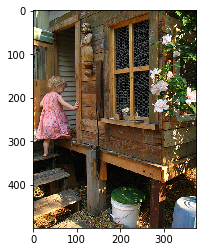

In [21]:
IMG_PATH = ('Flicker8k_Dataset/')

import cv2
import matplotlib.pyplot as plt

img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # CV2 read image as BGR by default

plt.imshow(img)
plt.show()

## 2.1 Data Cleaning

In [23]:
# We do not remove stopwords and don't do stemming to generate correct english
# We convert to lower-case and remove numbers and punctuations to reduce vocab size

In [30]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    
    return sentence

In [31]:
clean_text("A cat is sitting over the house #64")

'cat is sitting over the house'

In [32]:
# Clean the captions

In [33]:
for key, caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [34]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [35]:
# Saving the data to a text file

with open("desciptions_1.txt", "w") as file:
    file.write(str(descriptions))

## 2.2 Vocabulary

In [37]:
descriptions = None
with open("desciptions_1.txt",'r') as file:
    descriptions = file.read()
    
    
json_string = descriptions.replace("'","\"") # coverting to json acceptable string
descriptions = json.loads(json_string)

In [38]:
print(type(descriptions))

<class 'dict'>


In [41]:
vocab = set()

for key in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab size : %d"%len(vocab))

Vocab size : 8424


In [42]:
# Total words 
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words : %d"%len(total_words))

Total Words : 373837


In [43]:
# filter words from the vocab according to certain threshold frequency

In [44]:
import collections

counter = collections.Counter(total_words)
freq_count = dict(counter)
print(freq_count)

{'child': 1545, 'in': 18987, 'pink': 739, 'dress': 348, 'is': 9345, 'climbing': 507, 'up': 1302, 'set': 109, 'of': 6723, 'stairs': 109, 'an': 2432, 'entry': 1, 'way': 53, 'girl': 3328, 'going': 149, 'into': 1074, 'wooden': 284, 'building': 511, 'little': 1768, 'playhouse': 6, 'the': 18420, 'to': 3176, 'her': 1178, 'cabin': 4, 'black': 3848, 'dog': 8138, 'and': 8863, 'spotted': 38, 'are': 3505, 'fighting': 133, 'tri': 14, 'colored': 221, 'playing': 2008, 'with': 7765, 'each': 430, 'other': 773, 'on': 10746, 'road': 398, 'white': 3959, 'brown': 2578, 'spots': 29, 'staring': 57, 'at': 2916, 'street': 944, 'two': 5643, 'dogs': 2125, 'different': 46, 'breeds': 5, 'looking': 744, 'pavement': 48, 'moving': 41, 'toward': 146, 'covered': 372, 'paint': 62, 'sits': 577, 'front': 1386, 'painted': 64, 'rainbow': 22, 'hands': 246, 'bowl': 30, 'sitting': 1368, 'large': 1237, 'small': 1278, 'grass': 1622, 'plays': 526, 'fingerpaints': 3, 'canvas': 6, 'it': 401, 'there': 304, 'pigtails': 14, 'painting'

In [45]:
# Sorting this dictionary according to the freq count

sorted_freq_cnt = sorted(freq_count.items(), reverse = True, key = lambda x : x[1])

# Filtering
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1] > threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [46]:
print(total_words)

['in', 'the', 'on', 'is', 'and', 'dog', 'with', 'man', 'of', 'two', 'white', 'black', 'boy', 'are', 'woman', 'girl', 'to', 'wearing', 'at', 'people', 'water', 'red', 'young', 'brown', 'an', 'his', 'blue', 'dogs', 'running', 'through', 'playing', 'while', 'shirt', 'down', 'standing', 'ball', 'little', 'grass', 'snow', 'child', 'person', 'jumping', 'over', 'three', 'front', 'sitting', 'holding', 'up', 'field', 'small', 'by', 'large', 'green', 'one', 'group', 'yellow', 'her', 'walking', 'children', 'men', 'into', 'air', 'beach', 'near', 'mouth', 'jumps', 'another', 'for', 'street', 'runs', 'its', 'from', 'riding', 'stands', 'as', 'bike', 'girls', 'outside', 'other', 'off', 'out', 'rock', 'next', 'play', 'orange', 'looking', 'pink', 'player', 'camera', 'their', 'pool', 'hat', 'jacket', 'boys', 'women', 'around', 'behind', 'some', 'background', 'dirt', 'toy', 'soccer', 'sits', 'dressed', 'has', 'wall', 'mountain', 'walks', 'crowd', 'along', 'plays', 'stand', 'looks', 'building', 'park', 'cl

In [47]:
print(len(total_words)) # final vocab size

1845


## 3. Train/Test Preparation

In [48]:
train_file_data = readTextFile('Flickr8k_text/Flickr_8k.trainImages.txt')
test_file_data = readTextFile('Flickr8k_text/Flickr_8k.testImages.txt')

In [52]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
print(train)

['2513260012_03d33305cf', '2903617548_d3e38d7f88', '3338291921_fe7ae0c8f8', '488416045_1c6d903fe0', '2644326817_8f45080b87', '218342358_1755a9cce1', '2501968935_02f2cd8079', '2699342860_5288e203ea', '2638369467_8fc251595b', '2926786902_815a99a154', '2851304910_b5721199bc', '3423802527_94bd2b23b0', '3356369156_074750c6cc', '2294598473_40637b5c04', '1191338263_a4fa073154', '2380765956_6313d8cae3', '3197891333_b1b0fd1702', '3119887967_271a097464', '2276499757_b44dc6f8ce', '2506892928_7e79bec613', '2187222896_c206d63396', '2826769554_85c90864c9', '3097196395_ec06075389', '3603116579_4a28a932e2', '3339263085_6db9fd0981', '2532262109_87429a2cae', '2076906555_c20dc082db', '2502007071_82a8c639cf', '3113769557_9edbb8275c', '3325974730_3ee192e4ff', '1655781989_b15ab4cbff', '1662261486_db967930de', '2410562803_56ec09f41c', '2469498117_b4543e1460', '69710415_5c2bfb1058', '3414734842_beb543f400', '3006217970_90b42e6b27', '2192411521_9c7e488c5e', '3535879138_9281dc83d5', '2685788323_ceab14534a', '34

In [53]:
# Adding <start> and <end> token to our training data

train_descriptions = {}

for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)
        

In [54]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

## 4. Transfer Learning 

In [55]:
# Using ResNet50 model to extract features

### 4.1 Image Feature Extraction

In [56]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [57]:
model_new = Model(model.input,model.layers[-2].output)

In [58]:
def preprocess_img(img):
    img = image.load_img(img, target_size = (224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    
    # Normalisation
    img = preprocess_input(img)
    return img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


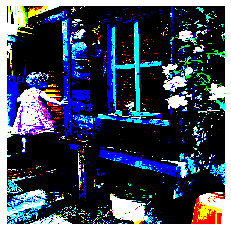

In [60]:
img = preprocess_img(IMG_PATH+"1000268201_693b08cb0e.jpg")
plt.imshow(img[0])
plt.axis('off')
plt.show()

In [65]:
def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    
    #print(feature_vector.shape)
    return feature_vector

In [66]:
encode_image(IMG_PATH+"1000268201_693b08cb0e.jpg")

array([0.06535922, 0.16782534, 0.3251761 , ..., 0.05107138, 0.32821208,
       1.0043364 ], dtype=float32)

In [68]:
start_t = time()
encoding_train = {}
# feature vector stored for each image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix % 100 == 0:
        print("Encoding in Progress time step %d"%ix)
        
end_t = time()
print("Total time taken :", end_t-start_t)

Encoding in Progress time step 0
Encoding in Progress time step 100
Encoding in Progress time step 200
Encoding in Progress time step 300
Encoding in Progress time step 400
Encoding in Progress time step 500
Encoding in Progress time step 600
Encoding in Progress time step 700
Encoding in Progress time step 800
Encoding in Progress time step 900
Encoding in Progress time step 1000
Encoding in Progress time step 1100
Encoding in Progress time step 1200
Encoding in Progress time step 1300
Encoding in Progress time step 1400
Encoding in Progress time step 1500
Encoding in Progress time step 1600
Encoding in Progress time step 1700
Encoding in Progress time step 1800
Encoding in Progress time step 1900
Encoding in Progress time step 2000
Encoding in Progress time step 2100
Encoding in Progress time step 2200
Encoding in Progress time step 2300
Encoding in Progress time step 2400
Encoding in Progress time step 2500
Encoding in Progress time step 2600
Encoding in Progress time step 2700
Enco

In [69]:
# Storing img_data on disk

with open("encoded_train_features.pkl", "wb") as file:
    pickle.dump(encoding_train, file)
    

In [126]:
start = time()
encoding_test = {}
# feature vector stored for each image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix % 100 == 0:
        print("Encoding in Progress time step %d"%ix)
        
end = time()
print("Total time taken :", end-start)

Encoding in Progress time step 0
Encoding in Progress time step 100
Encoding in Progress time step 200
Encoding in Progress time step 300
Encoding in Progress time step 400
Encoding in Progress time step 500
Encoding in Progress time step 600
Encoding in Progress time step 700
Encoding in Progress time step 800
Encoding in Progress time step 900
Total time taken : 179.2104790210724


In [127]:
with open("encoded_test_features.pkl", "wb") as file:
    pickle.dump(encoding_test, file)

### 4.2 Data pre-processing for Captions

In [73]:
len(total_words)

1845

In [74]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [75]:
print(len(idx_to_word))

1845


In [77]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size", vocab_size)

Vocab Size 1848


In [78]:
max_len = 0

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len, len(cap.split()))
        
print(max_len)

35


### 4.3 Data Loader (Generator)

In [79]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, batch_size):
    X2, X2, y = [],[],[]
    
    n = 0
    while True:
        for key, desc_list in train_descriptions.items():
            n+=1
            
            photo = encoding_train[key+".jpg"]
            
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    xi = pad_sequences([xi], maxlen = max_len, value=0,padding='post')[0]
                    yi = to_categorical([yi], num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield[[np.array(X1), np.array(X2)], np.array(y)]
                    
                    X1, X2, y =[],[],[]
                    n = 0
                    
                    

### 4.4 Word Embeddings

In [90]:
file = open("glove.6B.50d.txt")

In [91]:
embedding_index = {}

for line in file:
    
    values = line.split()
    
    word = values[0]
    word_embedding = np.array(values[1:], dtype = 'float')
    embedding_index[word] = word_embedding

In [92]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [93]:
file.close()

In [96]:
def get_embedding_matrix():
    
    emb_dim = 50
    matrix = np.zeros((vocab_size, emb_dim))
    
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_index is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [97]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

## 5. Model Architecture

In [99]:
#Image input

input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [100]:
#Caption input

input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero = True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [101]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Combined Model

model = Model(inputs = [input_img_features,input_captions], outputs = outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 35)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 35, 50)       92400       input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [102]:
# Pre-Initialise embedding layer
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [103]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

## 6. Train Model

In [105]:
epochs = 20
batch_size = 3

In [106]:
def train():
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_i,dx,max_len, batch_size)
        model.fit_generator(generator, epochs=1,steps_per_epoch = steps, verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')
        

In [107]:
model = load_model('./model_weights/model_9.h5')

## 7. Predictions

In [132]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #Greedy sampling
        word = idx_to_word[ypred]
        in_text += ' '+word
        
        if word == 'endseq':
            break
            
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

dog is running on track


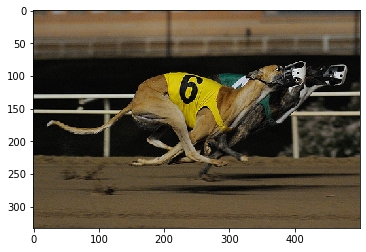

black and white dog is jumping over hurdle


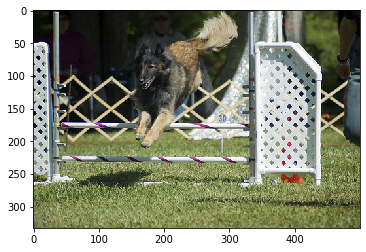

little girl in orange shirt is going down slide slide


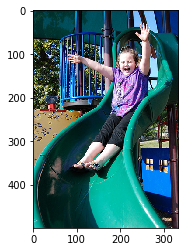

dog is running on the grass


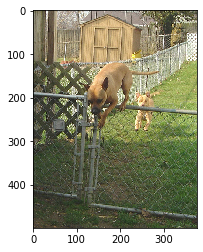

woman in pink shirt and brown shirt is holding child hand in hand hand


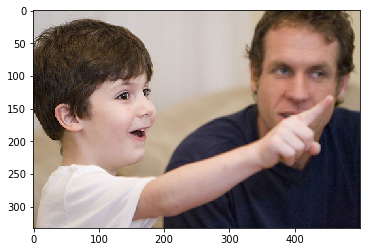

snowboarder in the air after the ice


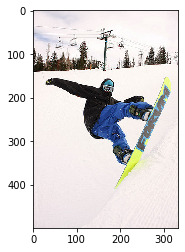

skateboarder in the air over the railing


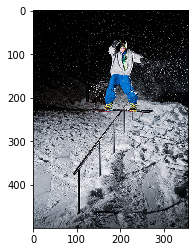

two dogs are playing with each other in the grass


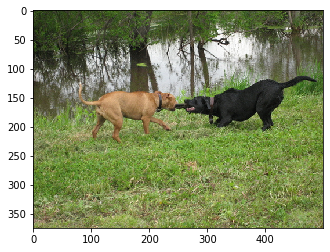

two dogs are running in the dry


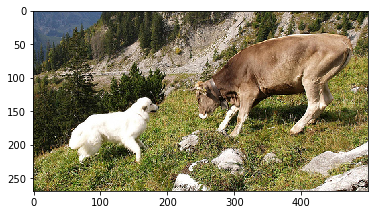

two dogs are running through field


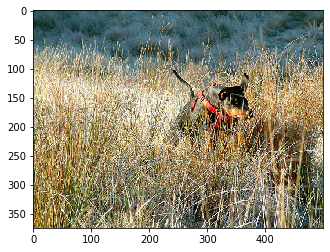

swimmer in black goggles is looking at the water


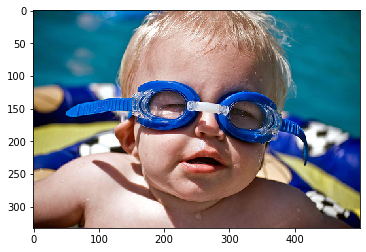

two dogs are playing with each other in the grass


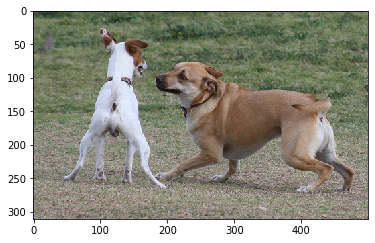

two riders are standing on top of mountain


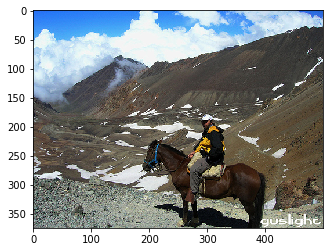

two dogs are playing with each other on the grass


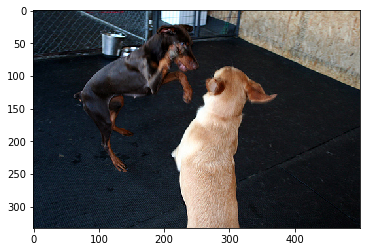

man and woman pose for picture


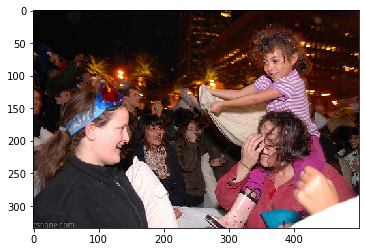

In [133]:
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    caption = predict_caption(photo_2048)
    print(caption)
    
    i = plt.imread(IMG_PATH+"/"+img_name+".jpg")
    plt.imshow(i)
    plt.show()